# 데이콘 이상탐지 데이터 분석
---

In [1]:
!pip install --upgrade matplotlib

In [2]:
!pip install shap

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import pywt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import shap

In [2]:
#밸브 개도율 압력계: p7, p10,p11,p13,p14,p15,p16,p18,p19,p20,p21,p22,p23

# M7펌프가 24/06/26 05:58 1에서 0으로 변함
# 압력계가 비정상이되면 14:20-부터 급격히 떨어지다가 정상화된 14:50부터 다시 올라감
- P가 anomaly 관측에 주요 변수로 보임(P8)
- 밸브 개도율 수시 변동과 p8 p9 사이 상관관계 가능
- Q4는 굉장히 중요한 변수다
- Q5가 완전 음에서 완전 양으로 바뀐다
- p7하고 q4가 상관관계 -1에 가까워 q4와 p7사이에 밸브는 개도율이 수시로 변동한다 
- p7이 압력이 높아졌을 때 밸브를 닫아서 q4의 유량이 감소했을 가능성이 있음
- 베르누이 원리에 의해서 정상상태에서는 유량과 압력이 음의 상관관계다
- 근데 anomaly상황에서 q5에서 양의 상관관계다
Anomaly 상황에서 유량과 압력이 양의 상관관계를 보이는 것은 시스템에 비정상적인 상태가 발생했음을 시사합니다. 이는 다음과 같은 상황을 나타낼 수 있습니다:
누수 발생: 파이프라인에 누수가 발생하면, 압력이 증가함에 따라 누수 지점을 통한 유량도 증가할 수 있습니다2. 이는 정상적인 흐름과는 다른 패턴을 보이게 됩니다.
막힘 현상: 파이프라인에 부분적인 막힘이 발생하면, 압력이 증가하면서 동시에 유량도 증가할 수 있습니다. 이는 막힘을 통과하기 위해 더 높은 압력이 필요하기 때문입니다2.
펌프 오작동: 시스템 내 펌프가 비정상적으로 작동하면, 압력과 유량이 동시에 증가하는 현상이 나타날 수 있습니다3.
밸브 오작동: 제어 밸브가 제대로 작동하지 않으면, 압력과 유량 사이의 정상적인 관계가 무너질 수 있습니다.
결론
이러한 관찰 결과는 시스템의 정상 상태와 비정상 상태를 구분하는 중요한 지표가 될 수 있습니다4. 유량과 압력 사이의 관계가 갑자기 변화하는 것은 시스템에 문제가 발생했음을 나타내는 신호일 수 있으며, 이를 통해 조기에 문제를 감지하고 대응할 수 있습니다. 따라서 이러한 패턴 변화를 모니터링하는 것은 수도 공급 시스템의 효율적인 관리와 유지보수에 매우 중요합니다5.

## 이미지 분석과 수압 데이터의 특성을 고려할 때, 다음과 같은 도메인 기반 전처리 방법들을 제안합니다:
1. 시간 도메인 전처리
- Moving Average Filter
세 번째 이미지에서 보이는 급격한 압력 변화 전후의 노이즈 제거
단기(5-10점) 및 장기(20-30점) 이동평균 비교로 변화 패턴 강조
- Exponential Smoothing
최근 데이터에 더 높은 가중치 부여
P8, P9의 급격한 하락 구간 전후의 패턴 포착에 효과적
2. 주파수 도메인 전처리
- Butterworth Filter
Low-pass filter로 고주파 노이즈 제거
압력 변화의 주요 패턴만 추출
차단 주파수: 0.1-0.2Hz 권장
- Wavelet Transform
다중 해상도 분석으로 급격한 압력 변화 감지
Daubechies 웨이블릿 사용 권장
레벨 3-4 분해로 이상 패턴 특성 추출
3. 압력 특성 기반 전처리
- Pressure Gradient Analysis
압력 변화율 계산 및 임계값 설정
급격한 하락 구간 감지에 효과적
- Differential Pressure
인접 압력계 간의 차이 분석
P7-P9 그룹 내 상대적 변화 패턴 포착
4. 통계적 전처리
- Z-score Normalization
압력 변동의 통계적 이상치 감지
이동 윈도우 기반 정규화로 지역적 변화 강조
- CUSUM (Cumulative Sum)
누적 편차 분석으로 변화 시점 탐지
압력 하락 시작점 감지에 효과적
이러한 전처리 방법들을 조합하여 두 번째 이미지의 LOF 성능을 개선할 수 있습니다.

## 이미지 분석 결과를 보면, 각 전처리 방법의 특징이 다음과 같이 나타납니다:
1. Butterworth 필터 적용 (주황색 그래프)
원본 신호의 고주파 노이즈를 효과적으로 제거
P8, P9의 급격한 하락 패턴은 유지하면서 부드러운 신호를 생성
세 번째 이미지의 anomaly 구간(빨간색 영역)의 특성을 잘 보존
2. EMA (녹색 그래프)
이동평균으로 단기적인 변동성 감소
압력 변화의 전반적인 트렌드를 잘 포착
급격한 하락 구간에서도 원신호의 특성을 유지
3. Gradient (빨간색 그래프)
압력 변화율을 명확하게 표시
anomaly 구간에서 큰 음수값으로 급격한 하락을 강조
정상 구간과 이상 구간의 차이가 뚜렷하게 나타남
이러한 전처리된 특성들은 LOF 모델의 입력으로 사용되어 P8, P9의 anomaly 탐지 성능을 개선할 수 있습니다.

이미지 분석을 바탕으로 다음과 같은 전처리와 앙상블 모델 구조를 제안합니다:
1. 전처리 단계
- 1차 전처리: EMA
span=10으로 설정하여 기본 노이즈 제거
급격한 압력 하락 패턴은 보존
전반적인 트렌드를 명확하게 포착
- 2차 전처리: Pressure Gradient
EMA 처리된 데이터의 변화율 계산
이상치 발생 시점의 특성을 강조
급격한 하락 구간에서 뚜렷한 신호 생성
2. 앙상블 모델 구조
- 1단계: Isolation Forest
leakage 기반 1차 필터링
contamination=0.01로 설정
전체적인 이상 구간 후보 선정
- 2단계: One-Class SVM
EMA + Pressure Gradient 특성 사용
필터링된 데이터에 대해 각 Pi별 독립 적용
비선형 커널로 이상치 경계 학습
3. 모델 결합 전략
Isolation Forest로 필터링된 구간 내
One-Class SVM의 예측 결과를 각 Pi_flag에 매핑
각 Pi별 독립적인 flag 예측 수행
이러한 구조는 이미지에서 보이는 P8, P9의 급격한 하락 패턴을 효과적으로 포착하면서도 false positive를 최소화할 수 있습니다.

# 데이터 정보

In [4]:
df_A = pd.read_csv("TRAIN_B.csv")

print(df_A.columns)
print("칼럼 수 : ",len(df_A.columns))
print("차원 : ",df_A.shape)


# 새로운 열 생성:
df_A['leakage'] = df_A['Q1'] - df_A['Q2'] -df_A['Q3'] - df_A['Q4']

Index(['timestamp', 'Q1', 'Q2', 'Q3', 'Q4', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6',
       'P7', 'P8', 'P9', 'P10', 'anomaly', 'P1_flag', 'P2_flag', 'P3_flag',
       'P4_flag', 'P5_flag', 'P6_flag', 'P7_flag', 'P8_flag', 'P9_flag',
       'P10_flag'],
      dtype='object')
칼럼 수 :  26
차원 :  (41760, 26)


In [5]:
# 압력계 데이터 선택
pressure_cols = [f'P{i}' for i in range(1, 11)]
df_pressure = df_A[pressure_cols]

In [6]:
# 1. Butterworth 저역통과 필터 적용
#cutoff 주파수 선택이 중요
#너무 낮으면 중요한 변화까지 제거하고 너무 높으면 노이즈가 남음
#필터 차수(order)조정 필요
#높으면 더 급격한 차단특성, 낮은 차수는 더 부드러운 필터링
# 1. Butterworth 필터 적용
def apply_butterworth(data, cutoff=0.1, fs=1.0, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

In [7]:
# 2. Exponential Moving Average with Pressure Gradient
def apply_exp_ma_with_gradient(data, alpha=0.1):
    ema = data.ewm(alpha=alpha).mean()
    gradient = np.gradient(ema)
    return ema, gradient

In [8]:
def apply_wavelet_transform(data, wavelet='db4', level=3):
    # 웨이블렛 분해
    coeffs = pywt.wavedec(data, wavelet, level=level)
    # 근사값(cA)과 상세값(cD) 추출
    cA = coeffs[0]
    cD = coeffs[1:]
    
    # 원본 길이에 맞춰 재구성
    reconstructed = pywt.waverec(coeffs, wavelet)
    
    # 원본 데이터 길이에 맞추기
    if len(reconstructed) > len(data):
        reconstructed = reconstructed[:len(data)]
    elif len(reconstructed) < len(data):
        # 부족한 부분을 0으로 패딩
        padding = np.zeros(len(data) - len(reconstructed))
        reconstructed = np.concatenate([reconstructed, padding])
    
    return reconstructed, cA


In [9]:
# 전처리 적용
df_butter = pd.DataFrame(index=df_pressure.index)
df_ema = pd.DataFrame(index=df_pressure.index)
df_gradient = pd.DataFrame(index=df_pressure.index)
df_wavelet = pd.DataFrame(index=df_pressure.index)

In [10]:
for col in pressure_cols:
    # Butterworth 필터 적용
    df_butter[col] = apply_butterworth(df_pressure[col].values)
    # EMA와 Gradient 적용
    ema, grad = apply_exp_ma_with_gradient(df_pressure[col])
    df_ema[col] = ema
    df_gradient[col] = grad
    # 웨이블렛 변환 적용
    wavelet_rec, _ = apply_wavelet_transform(df_pressure[col].values)
    df_wavelet[col] = wavelet_rec[:len(df_pressure)]

In [11]:
# 시각화
# 시각화 함수 수정
def plot_preprocessing_comparison(original, butter, ema, gradient, wavelet, col):
    plt.figure(figsize=(15, 12))
    
    # 원본 데이터
    plt.subplot(5, 1, 1)
    plt.plot(original[col], label='Original')
    plt.title(f'{col} - Original Data')
    plt.legend()
    
    # Butterworth 필터 결과
    plt.subplot(5, 1, 2)
    plt.plot(butter[col], label='Butterworth', color='orange')
    plt.title(f'{col} - Butterworth Filtered')
    plt.legend()
    
    # EMA 결과
    plt.subplot(5, 1, 3)
    plt.plot(ema[col], label='EMA', color='green')
    plt.title(f'{col} - Exponential Moving Average')
    plt.legend()
    
    # Gradient 결과
    plt.subplot(5, 1, 4)
    plt.plot(gradient[col], label='Pressure Gradient', color='red')
    plt.title(f'{col} - Pressure Gradient')
    plt.legend()
    
    # 웨이블렛 변환 결과
    plt.subplot(5, 1, 5)
    plt.plot(wavelet[col], label='Wavelet Transform', color='purple')
    plt.title(f'{col} - Wavelet Transform')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



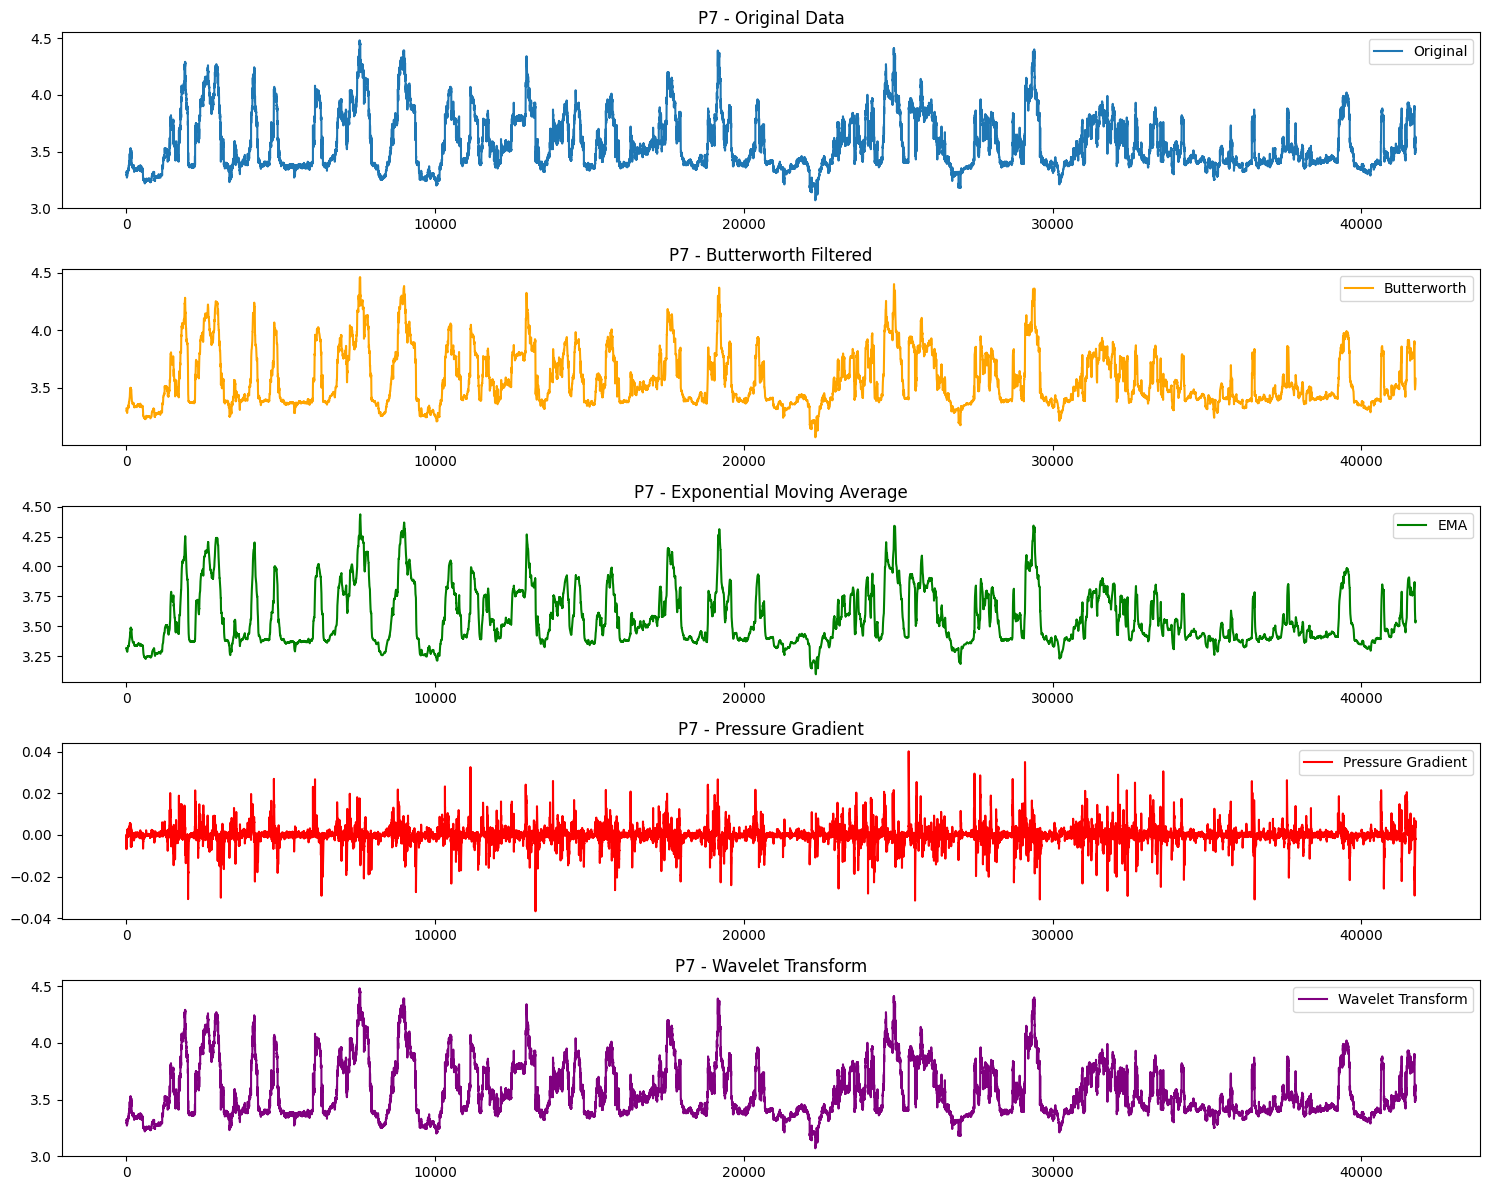

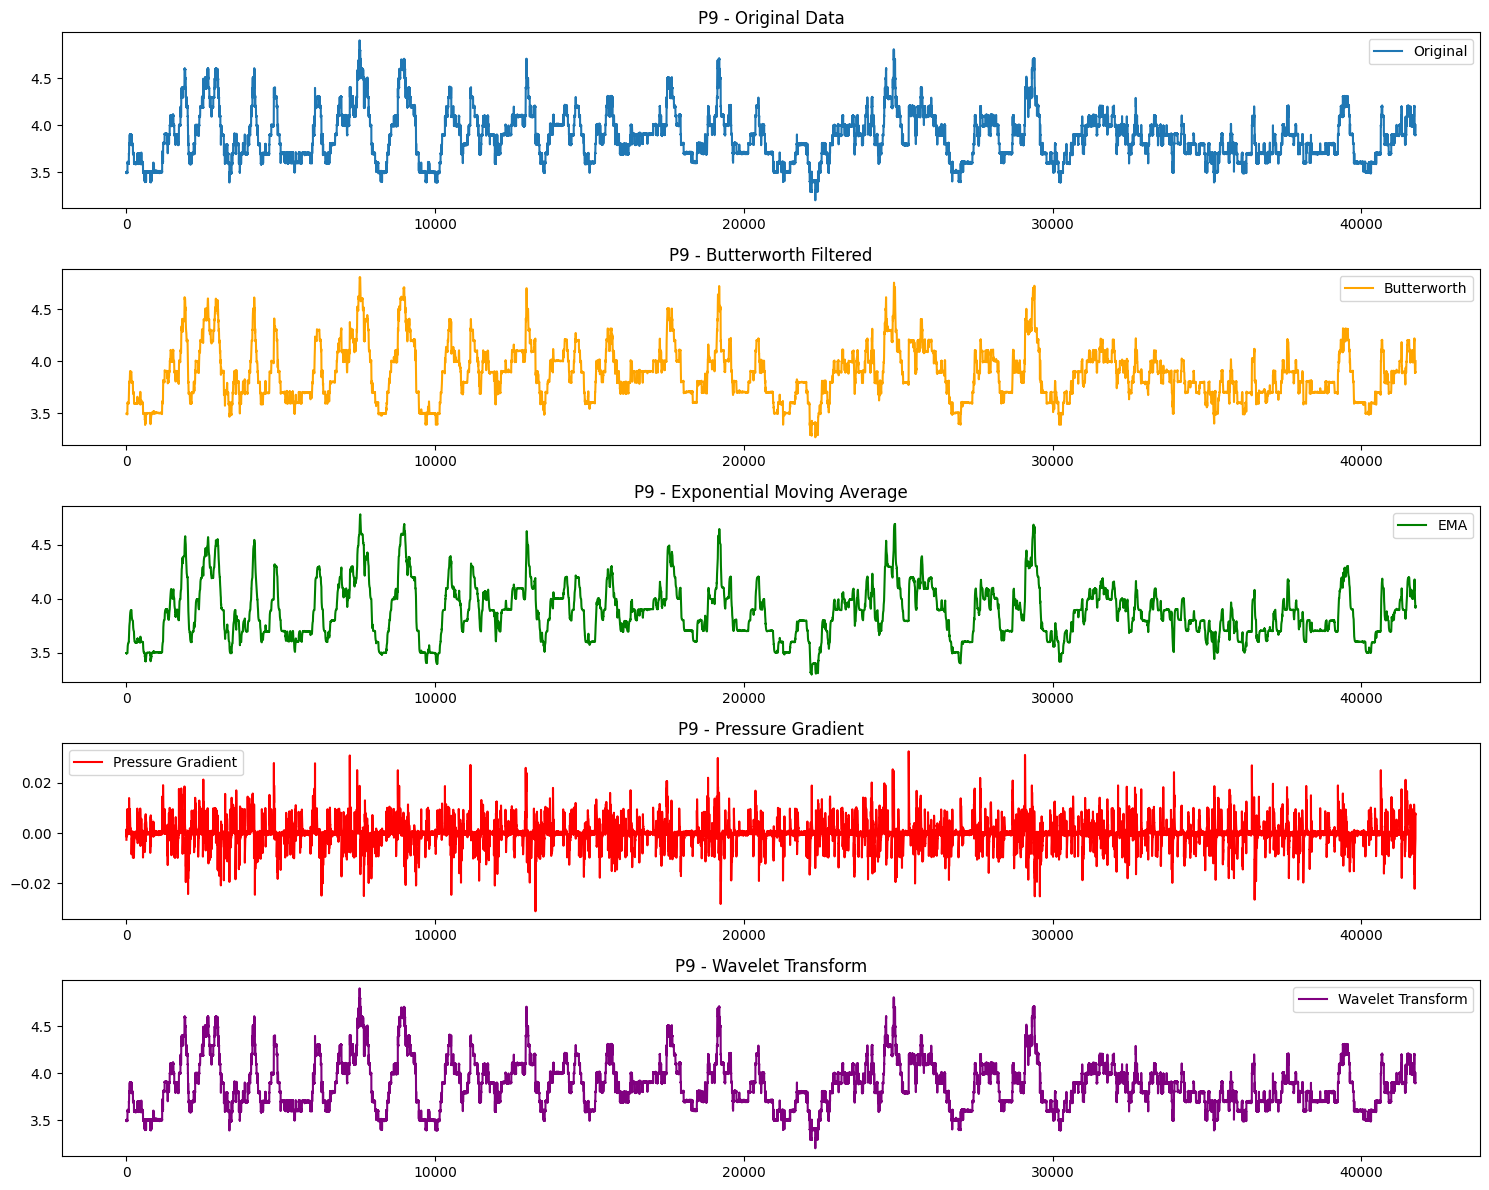

In [12]:
# P8, P9에 대해 시각화
for col in ['P7','P8', 'P9']:
    plot_preprocessing_comparison(
        df_pressure, 
        df_butter, 
        df_ema, 
        df_gradient,
        df_wavelet,
        col
    )

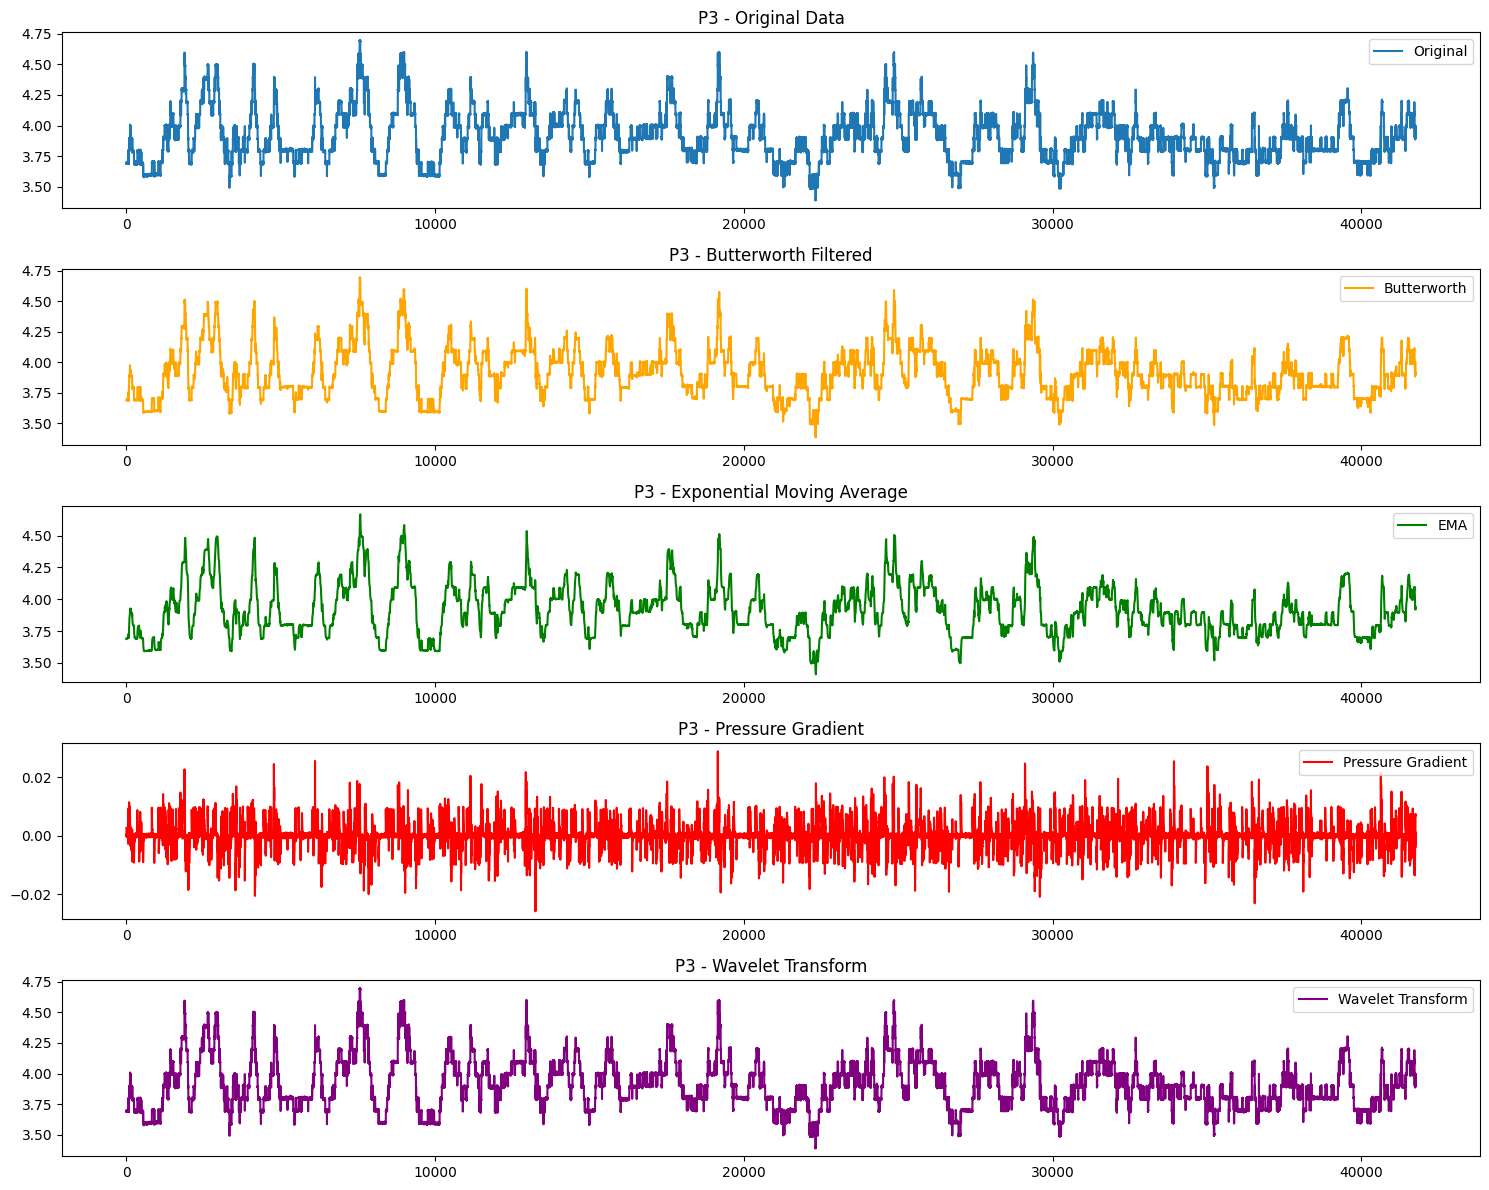

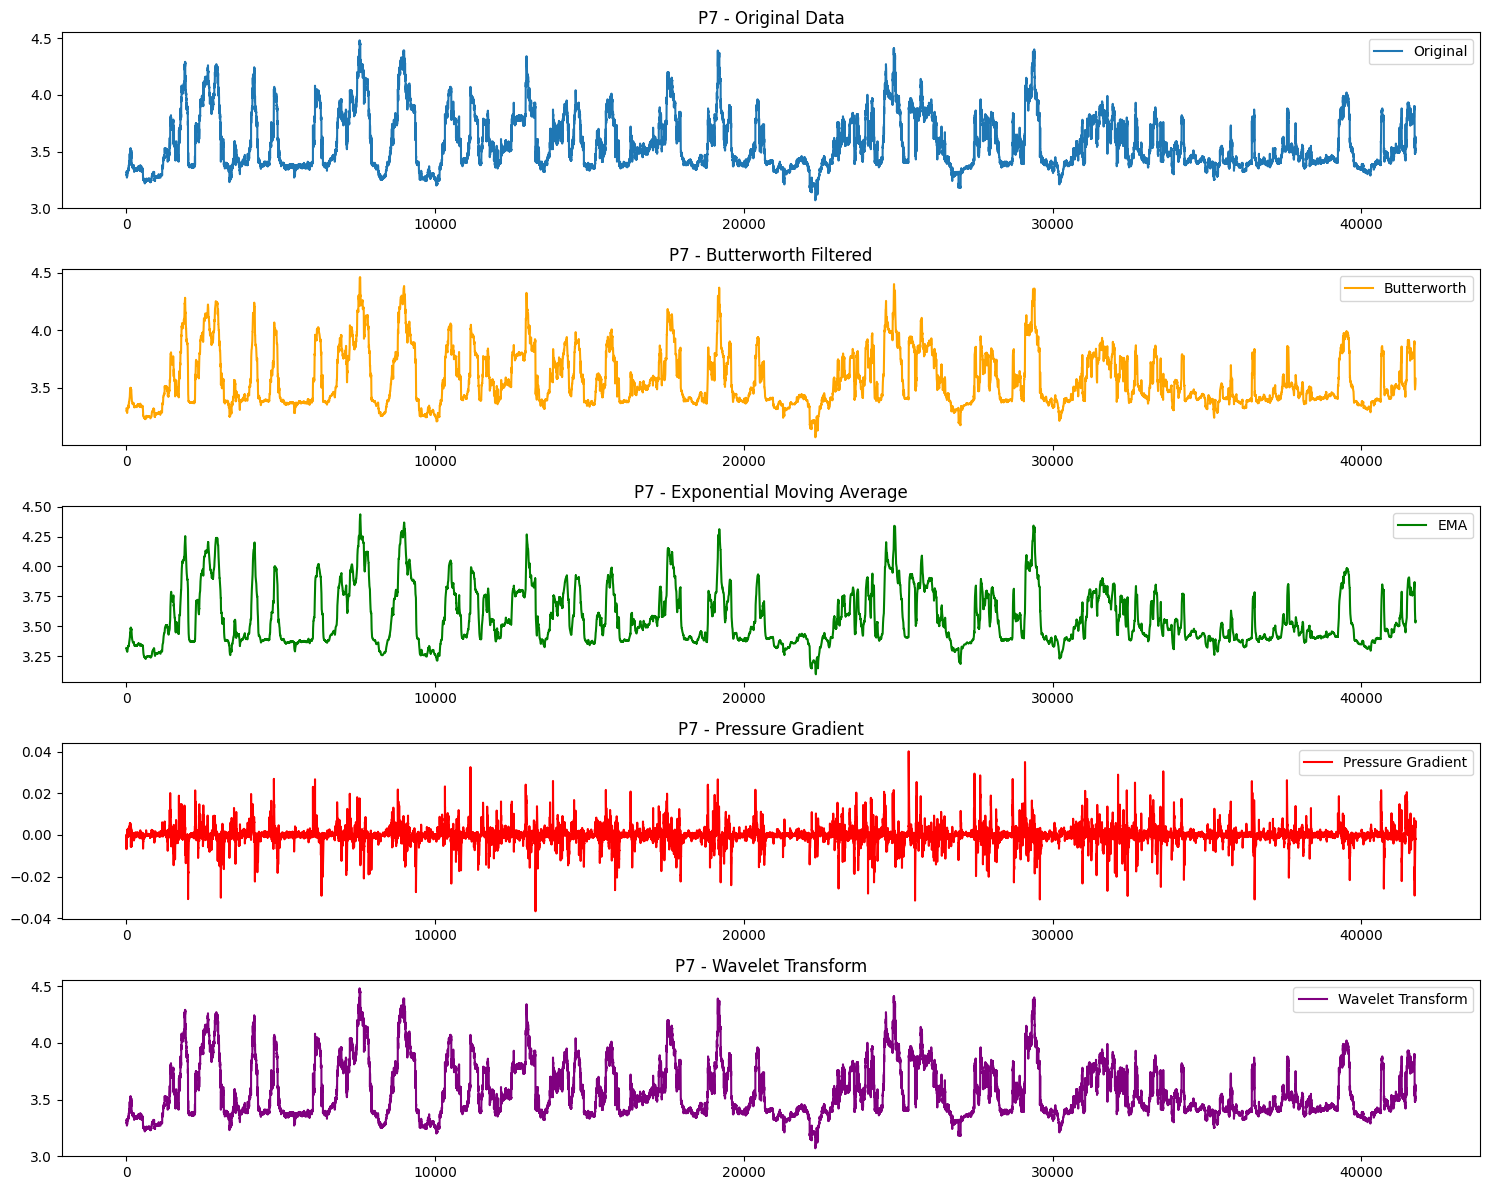

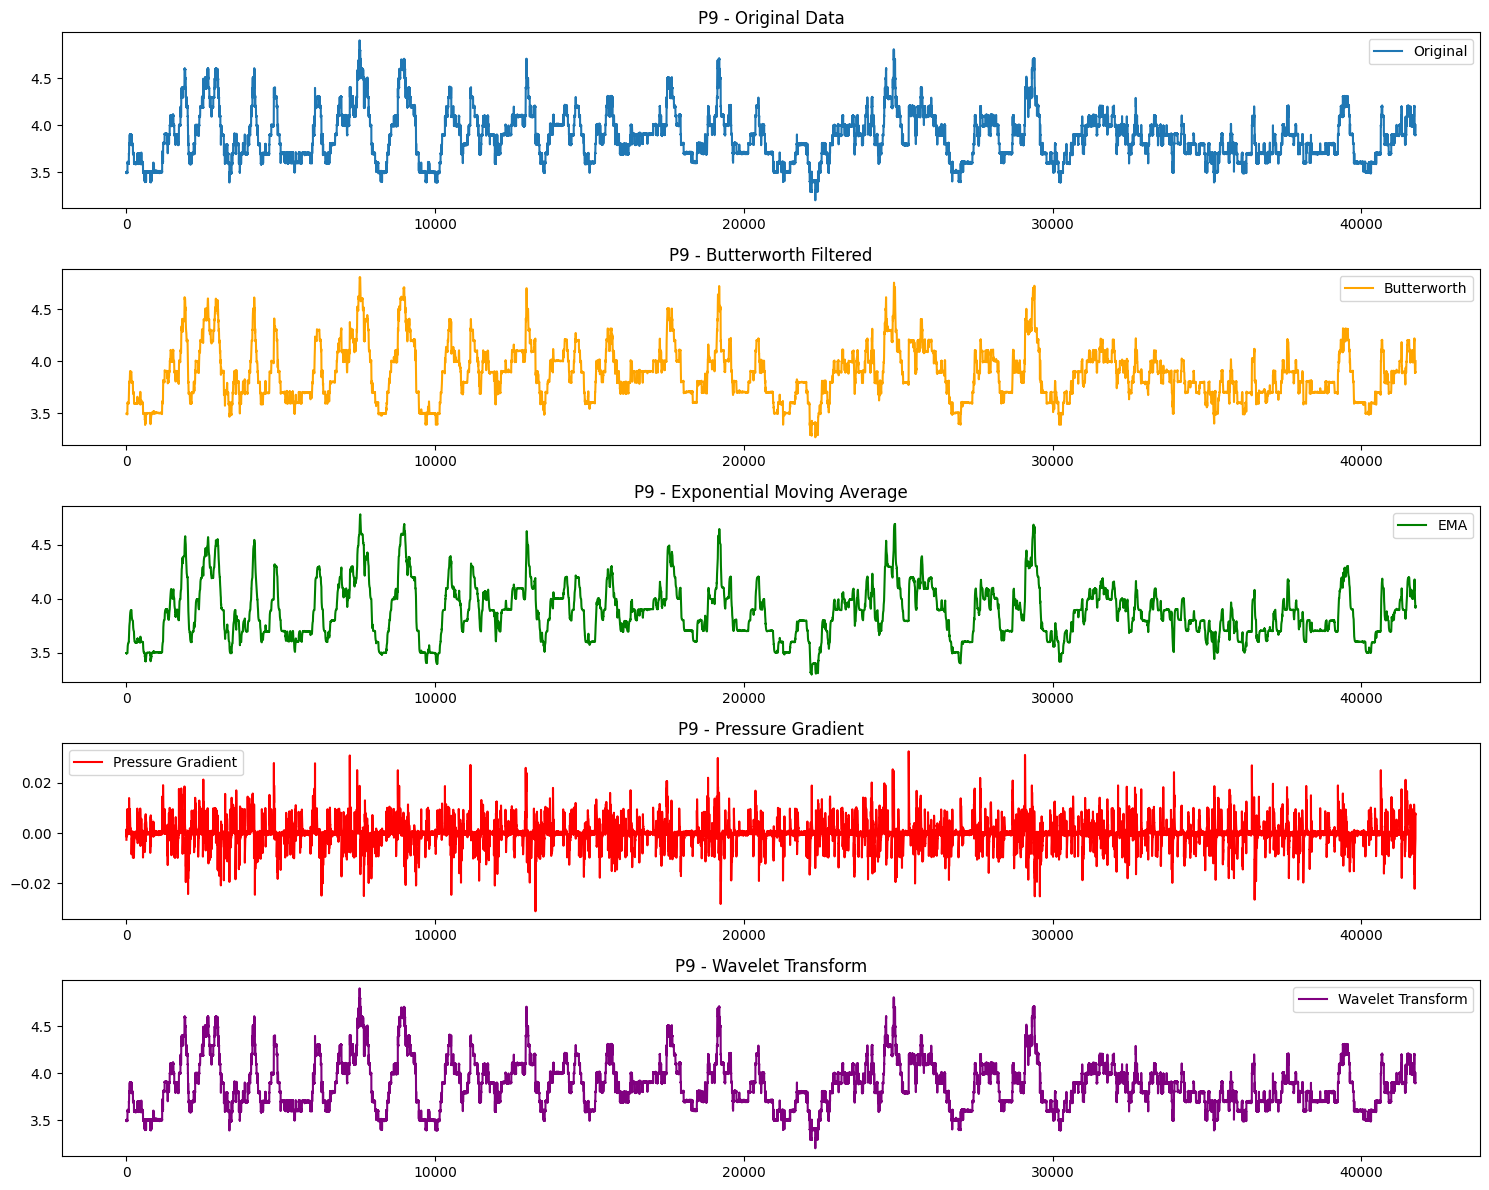

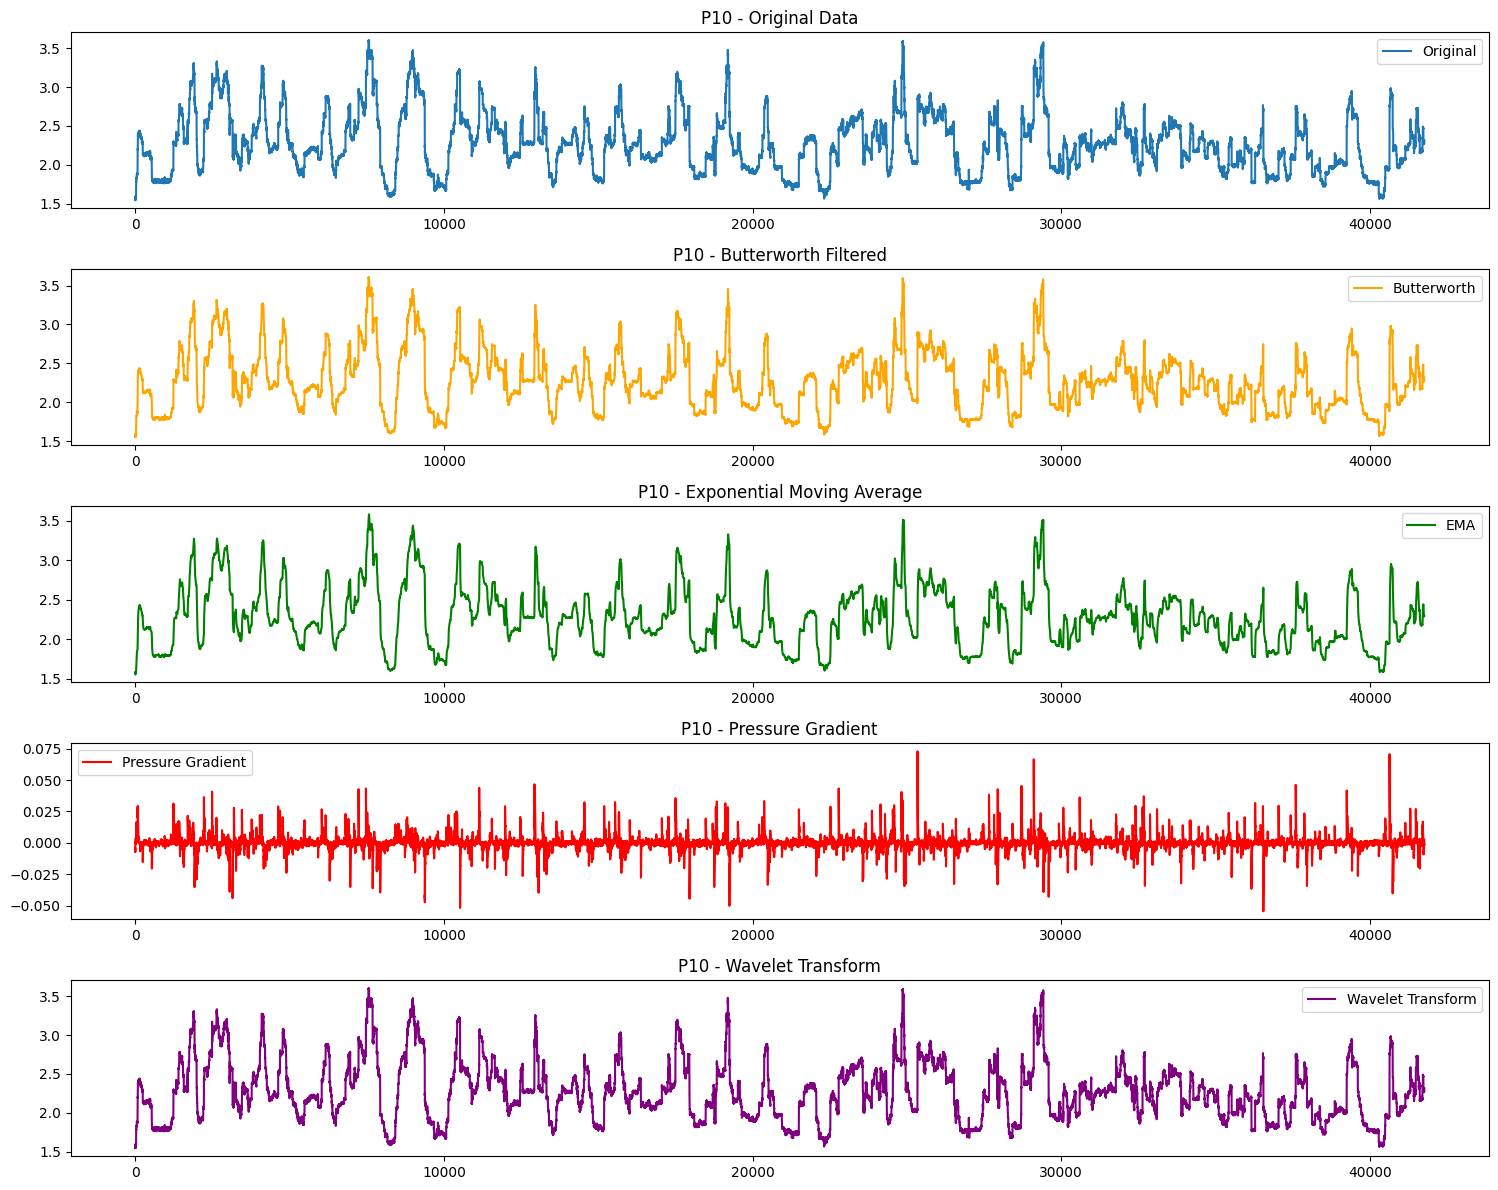

In [13]:
# P8, P9에 대해 시각화
for col in pressure_cols:
    plot_preprocessing_comparison(
        df_pressure, 
        df_butter, 
        df_ema, 
        df_gradient,
        df_wavelet,
        col
    )

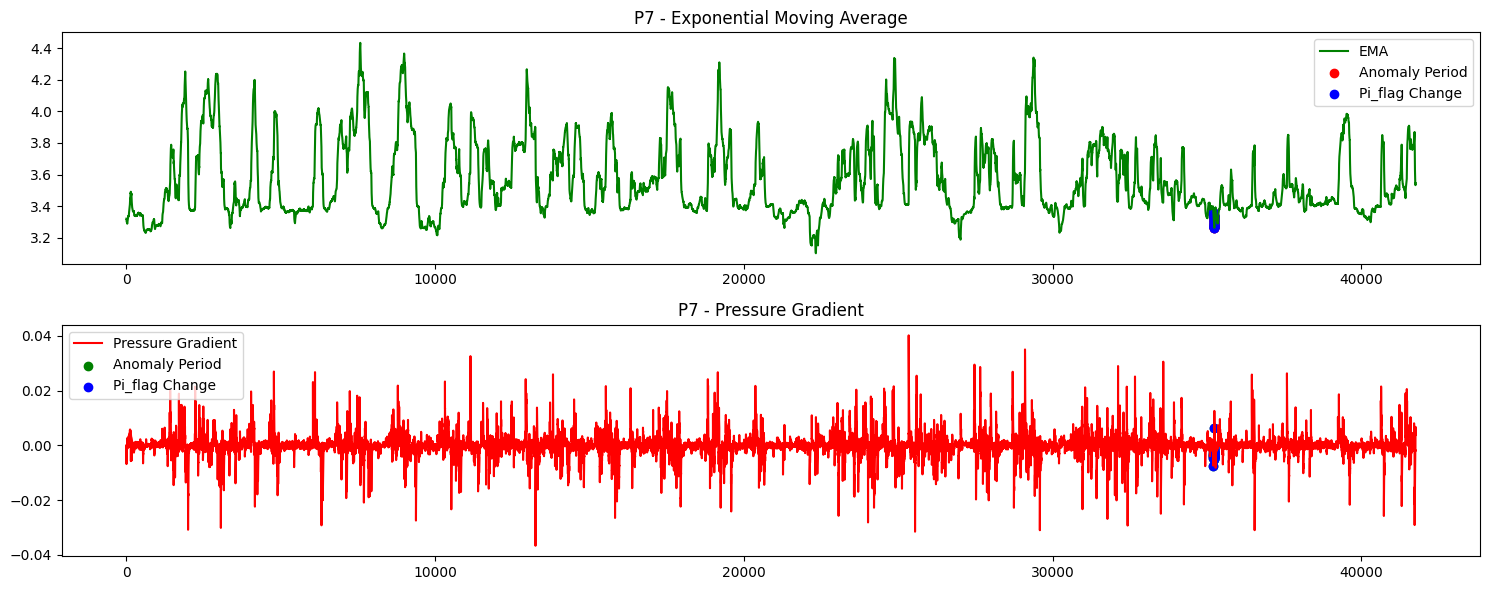

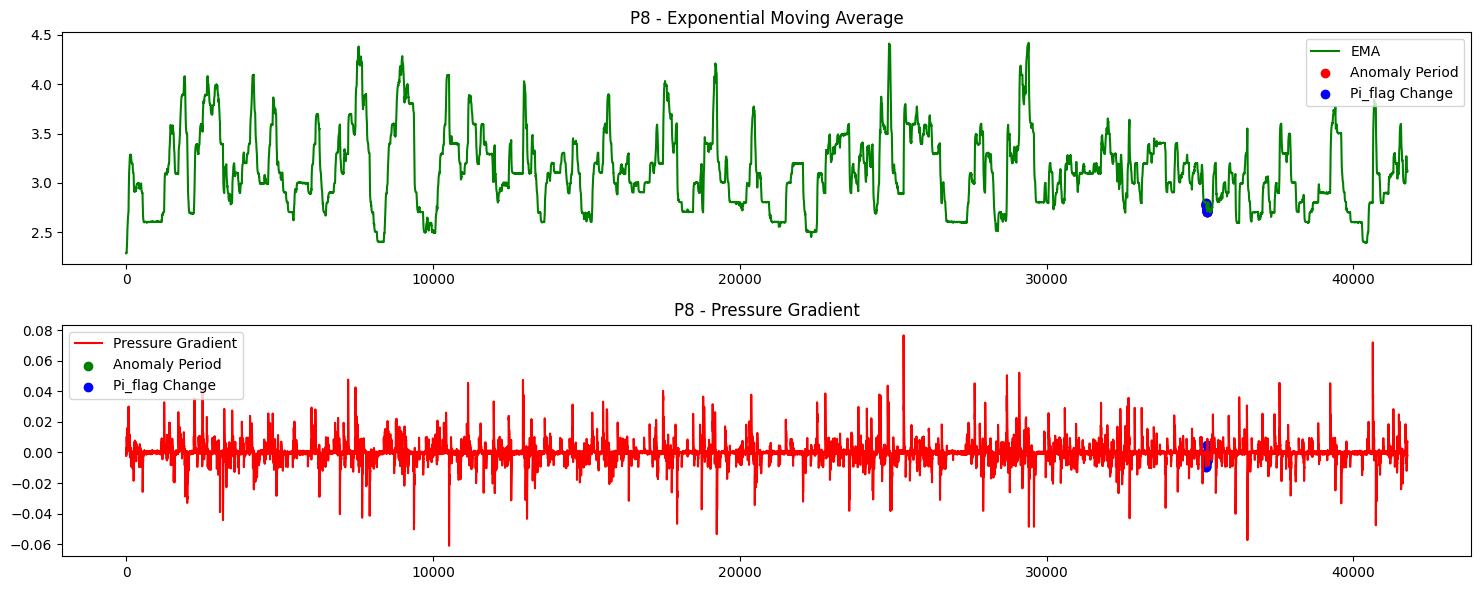

In [14]:
# 시각화 함수
def plot_pressure_analysis(col):
    # 1. EMA 시각화
    plt.figure(figsize=(15, 6))
    plt.subplot(2, 1, 1)
    plt.plot(df_ema[col], label='EMA', color='green')
    
    # anomaly 기간 표시
    anomaly_period = df_A[df_A['anomaly'] == 1].index
    plt.scatter(anomaly_period, df_ema.loc[anomaly_period, col], 
               color='red', label='Anomaly Period')
    
    # Pi_flag 변화 표시
    flag_changes = df_A[df_A[f'{col}_flag'] == 1].index
    plt.scatter(flag_changes, df_ema.loc[flag_changes, col], 
               color='blue', label='Pi_flag Change')
    
    plt.title(f'{col} - Exponential Moving Average')
    plt.legend()
    
    # 2. Pressure Gradient 시각화
    plt.subplot(2, 1, 2)
    plt.plot(df_gradient[col], label='Pressure Gradient', color='red')
    
    # anomaly 기간 표시
    plt.scatter(anomaly_period, df_gradient.loc[anomaly_period, col], 
               color='green', label='Anomaly Period')
    
    # Pi_flag 변화 표시
    plt.scatter(flag_changes, df_gradient.loc[flag_changes, col], 
               color='blue', label='Pi_flag Change')
    
    plt.title(f'{col} - Pressure Gradient')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# P8, P9에 대해 시각화
for col in ['P7','P8','P9']:
    plot_pressure_analysis(col)

In [15]:
def enhanced_preprocessing(df, pressure_cols, ema_span=20):
    preprocessed_features = {}
    
    for col in pressure_cols:
        # 1. EMA로 노이즈 제거
        ema = df[col].ewm(span=ema_span, adjust=False).mean()
        
        # 2. 하락 구간 식별
        gradient = ema.diff()
        drop_mask = gradient < 0
        
        # 3. 하락 구간 특성 추출
        # 하락 기간: 연속된 하락 구간의 길이
        drop_duration = pd.Series(0, index=df.index)
        duration_count = 0
        for i, is_dropping in enumerate(drop_mask):
            if is_dropping:
                duration_count += 1
            else:
                duration_count = 0
            drop_duration.iloc[i] = duration_count
        
        # 하락 폭: 시작점 대비 현재 하락량
        drop_magnitude = pd.Series(0.0, index=df.index)
        start_value = ema.iloc[0]
        for i, is_dropping in enumerate(drop_mask):
            if is_dropping:
                drop_magnitude.iloc[i] = start_value - ema.iloc[i]
            else:
                start_value = ema.iloc[i]
        
        # 하락 속도: gradient의 크기
        drop_speed = gradient.abs() * drop_mask
        
        # 결과 저장
        preprocessed_features[f'{col}_ema'] = ema
        preprocessed_features[f'{col}_drop_duration'] = drop_duration
        preprocessed_features[f'{col}_drop_magnitude'] = drop_magnitude
        preprocessed_features[f'{col}_drop_speed'] = drop_speed
        
    return pd.DataFrame(preprocessed_features, index=df.index)

In [16]:
# 전처리 적용
pressure_cols = [f'P{i}' for i in range(1, 11)]
preprocessed_df = enhanced_preprocessing(df_A, pressure_cols)

In [17]:
def plot_preprocessing_results(df_A, preprocessed_df, col):
    plt.figure(figsize=(15, 10))
    
    # 원본 데이터와 EMA
    plt.subplot(3, 1, 1)
    plt.plot(df_A[col], label='Original', alpha=0.7)
    plt.plot(preprocessed_df[f'{col}_ema'], label='EMA', alpha=0.7)
    
    # Pi_flag 변화 지점 표시
    flag_changes = df_A[df_A[f'{col}_flag'] == 1].index
    plt.scatter(flag_changes, df_A.loc[flag_changes, col],
               color='red', marker='*', s=100, label='Pi_flag Change')
    plt.title(f'{col} - Original and EMA')
    plt.legend()
    
    # 하락 특성
    plt.subplot(3, 1, 2)
    plt.plot(preprocessed_df[f'{col}_drop_magnitude'], label='Drop Magnitude', color='red')
    plt.plot(preprocessed_df[f'{col}_drop_speed'], label='Drop Speed', color='blue')
    plt.scatter(flag_changes, 
               preprocessed_df.loc[flag_changes, f'{col}_drop_magnitude'],
               color='red', marker='*', s=100, label='Pi_flag Change')
    plt.title('Drop Characteristics')
    plt.legend()
    
    # 하락 기간
    plt.subplot(3, 1, 3)
    plt.plot(preprocessed_df[f'{col}_drop_duration'], label='Drop Duration', color='green')
    plt.scatter(flag_changes,
               preprocessed_df.loc[flag_changes, f'{col}_drop_duration'],
               color='red', marker='*', s=100, label='Pi_flag Change')
    plt.title('Drop Duration')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


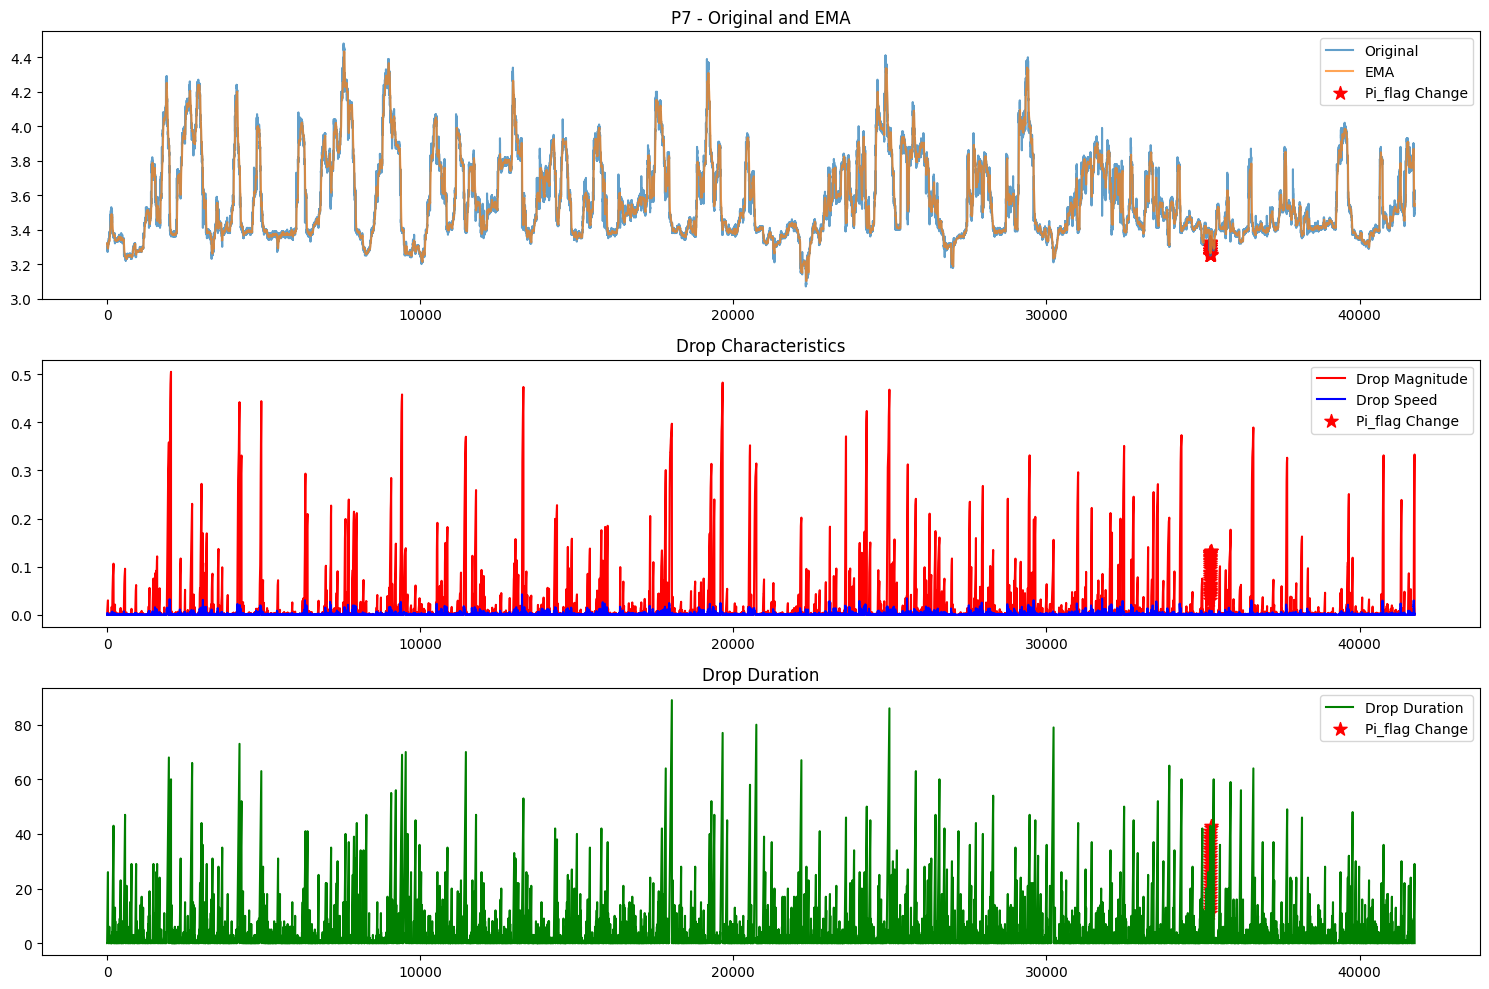

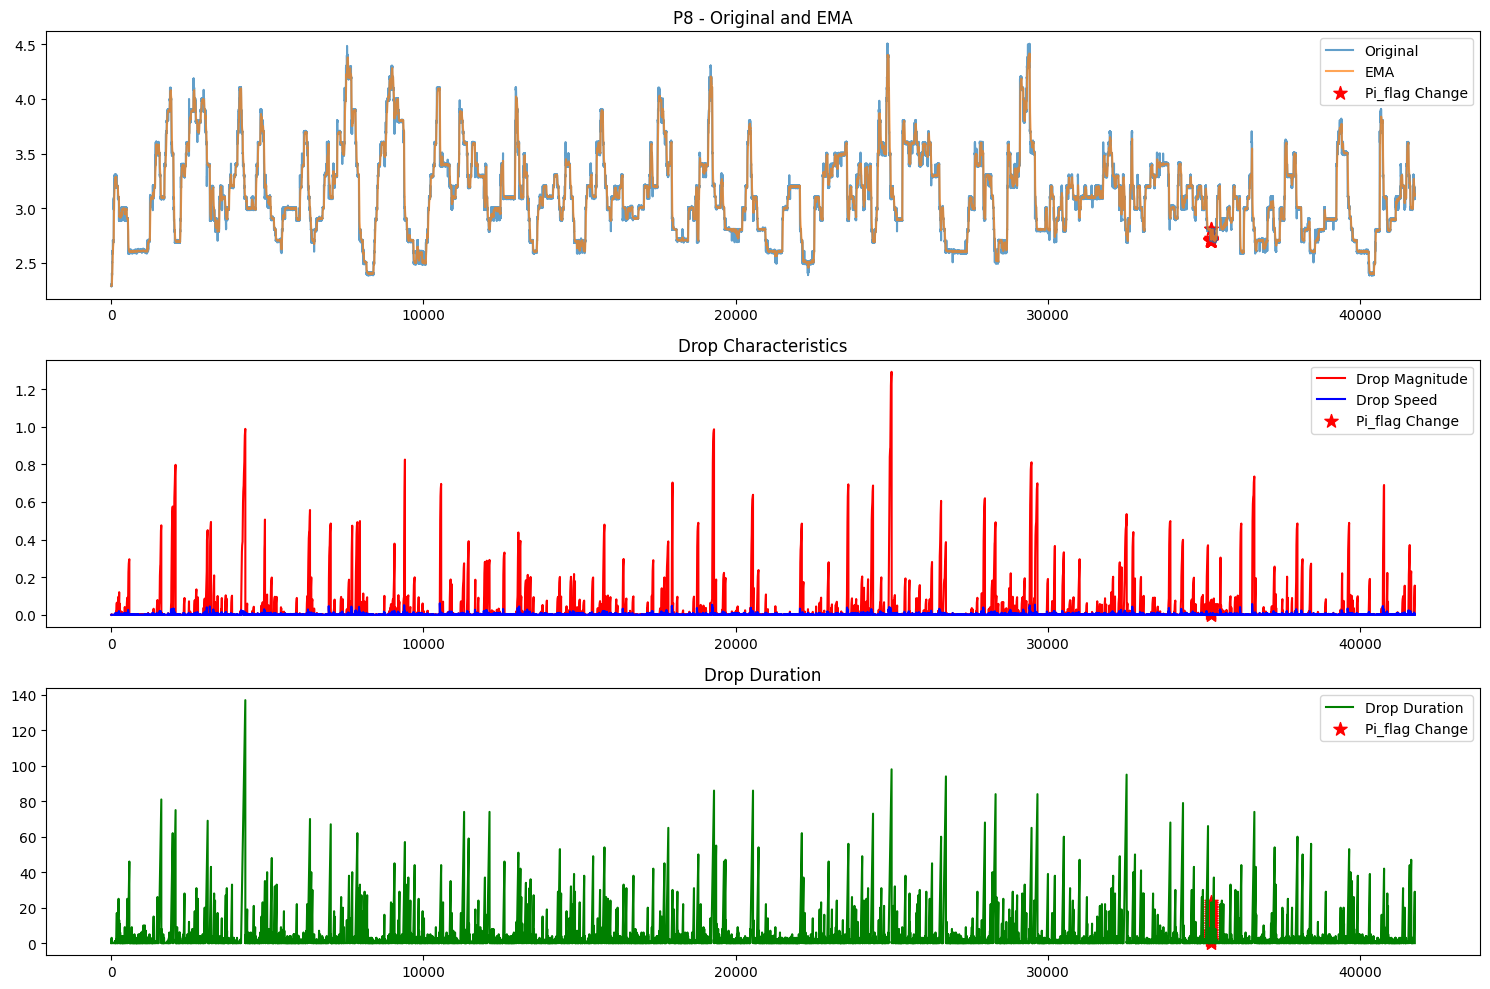

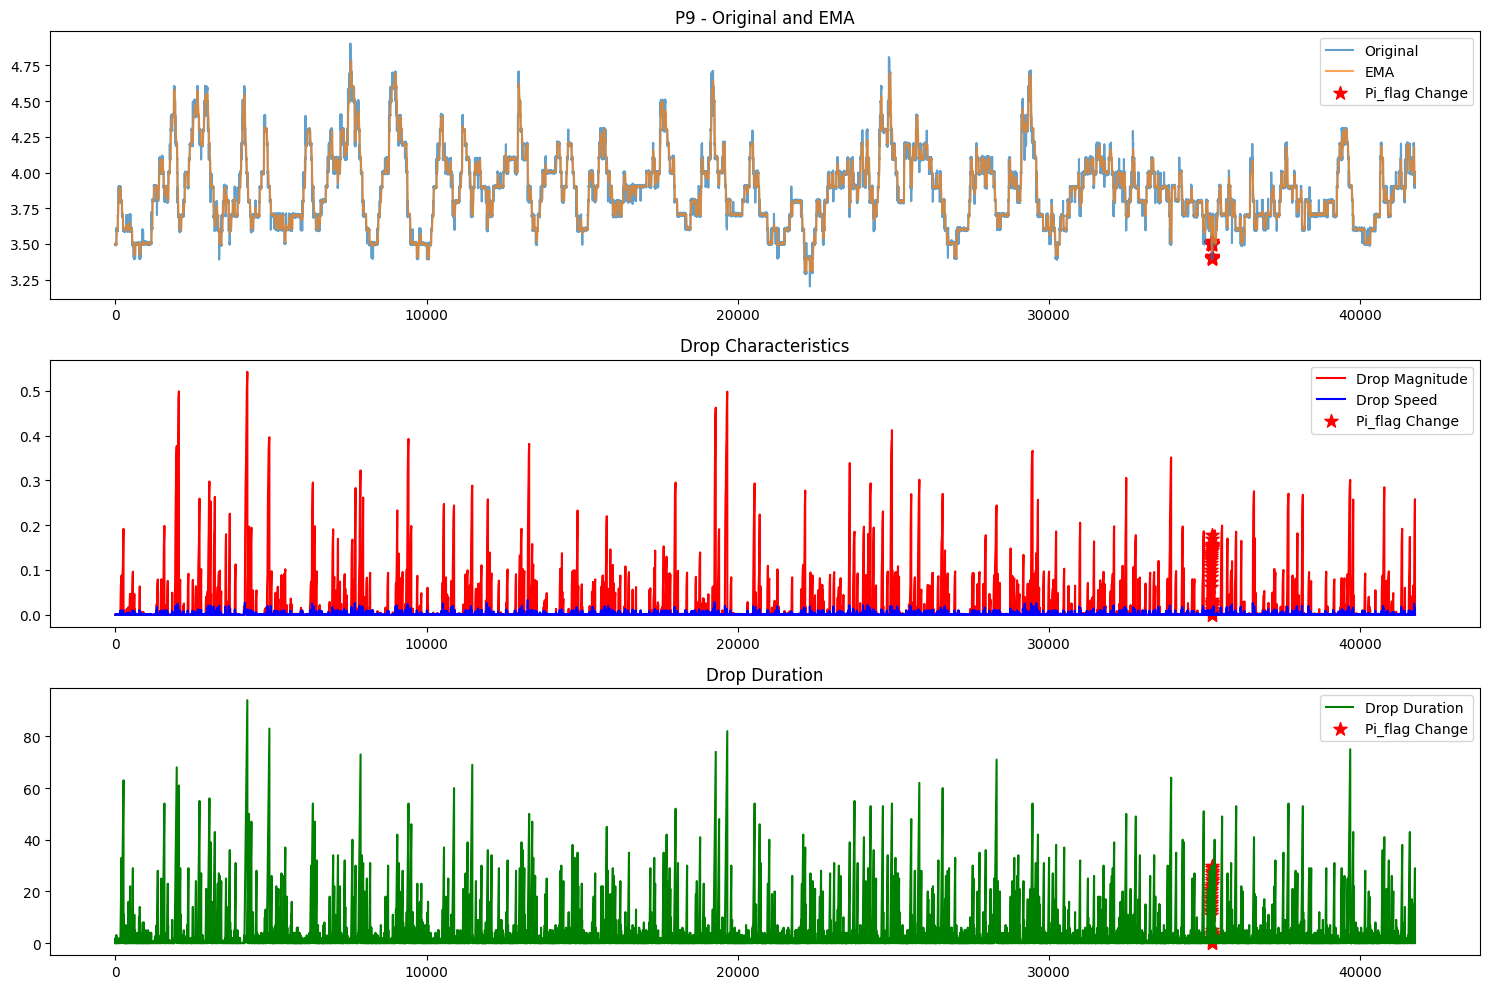

In [18]:
# P8, P9에 대해 결과 시각화
for col in ['P7','P8', 'P9']:
    plot_preprocessing_results(df_A, preprocessed_df, col)

In [19]:
def detect_pressure_anomalies_svm(preprocessed_df, pressure_cols, nu=0.01):
    results = {}
    
    for col in pressure_cols:
        # 하락 구간에 대한 특성 선택
        features = pd.DataFrame({
            'duration': preprocessed_df[f'{col}_drop_duration'],
            'magnitude': preprocessed_df[f'{col}_drop_magnitude'],
            'speed': preprocessed_df[f'{col}_drop_speed']
        })
        
        # 하락 구간만 선택
        drop_mask = features['speed'] > 0
        if not drop_mask.any():
            results[f'{col}_svm_anomaly'] = np.zeros(len(preprocessed_df))
            continue
            
        X = features[drop_mask]
        
        # 스케일링
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # One-Class SVM 적용:nu값이 중요함, gamma 파라미터가 auto이면 특성간 관계 강화
        svm = OneClassSVM(
            kernel='rbf',
            nu=0.1,
            gamma='auto'
        )
        
        # 예측
        predictions = np.zeros(len(preprocessed_df))
        drop_indices = X.index
        svm_predictions = svm.fit_predict(X_scaled)
        predictions[drop_indices] = svm_predictions
        
        # 결과 저장 (-1을 1로, 1을 0으로 변환)
        results[f'{col}_svm_anomaly'] = np.where(predictions == -1, 1, 0)
    
    return pd.DataFrame(results, index=preprocessed_df.index)

In [20]:
# 모델 적용
pressure_cols = [f'P{i}' for i in range(1, 11)]
svm_results = detect_pressure_anomalies_svm(preprocessed_df, pressure_cols)

In [21]:
# 결과 평가
def evaluate_svm_results(original_df, svm_results, pressure_cols):
    for col in pressure_cols:
        true_flags = original_df[original_df[f'{col}_flag'] == 1]
        detected_flags = svm_results[svm_results[f'{col}_svm_anomaly'] == 1]
        matching = len(set(true_flags.index) & set(detected_flags.index))
        
        print(f"\n=== {col} 평가 결과 ===")
        print(f"실제 flag 수: {len(true_flags)}")
        print(f"탐지된 이상 수: {len(detected_flags)}")
        print(f"일치하는 수: {matching}")
        print(f"정확도: {matching/len(true_flags)*100:.2f}%" if len(true_flags) > 0 else "정확도: N/A")

In [22]:
# 평가 수행
evaluate_svm_results(df_A, svm_results, ['P7','P8', 'P9'])


=== P7 평가 결과 ===
실제 flag 수: 33
탐지된 이상 수: 2111
일치하는 수: 0
정확도: 0.00%

=== P8 평가 결과 ===
실제 flag 수: 33
탐지된 이상 수: 2006
일치하는 수: 0
정확도: 0.00%

=== P9 평가 결과 ===
실제 flag 수: 33
탐지된 이상 수: 2126
일치하는 수: 4
정확도: 12.12%


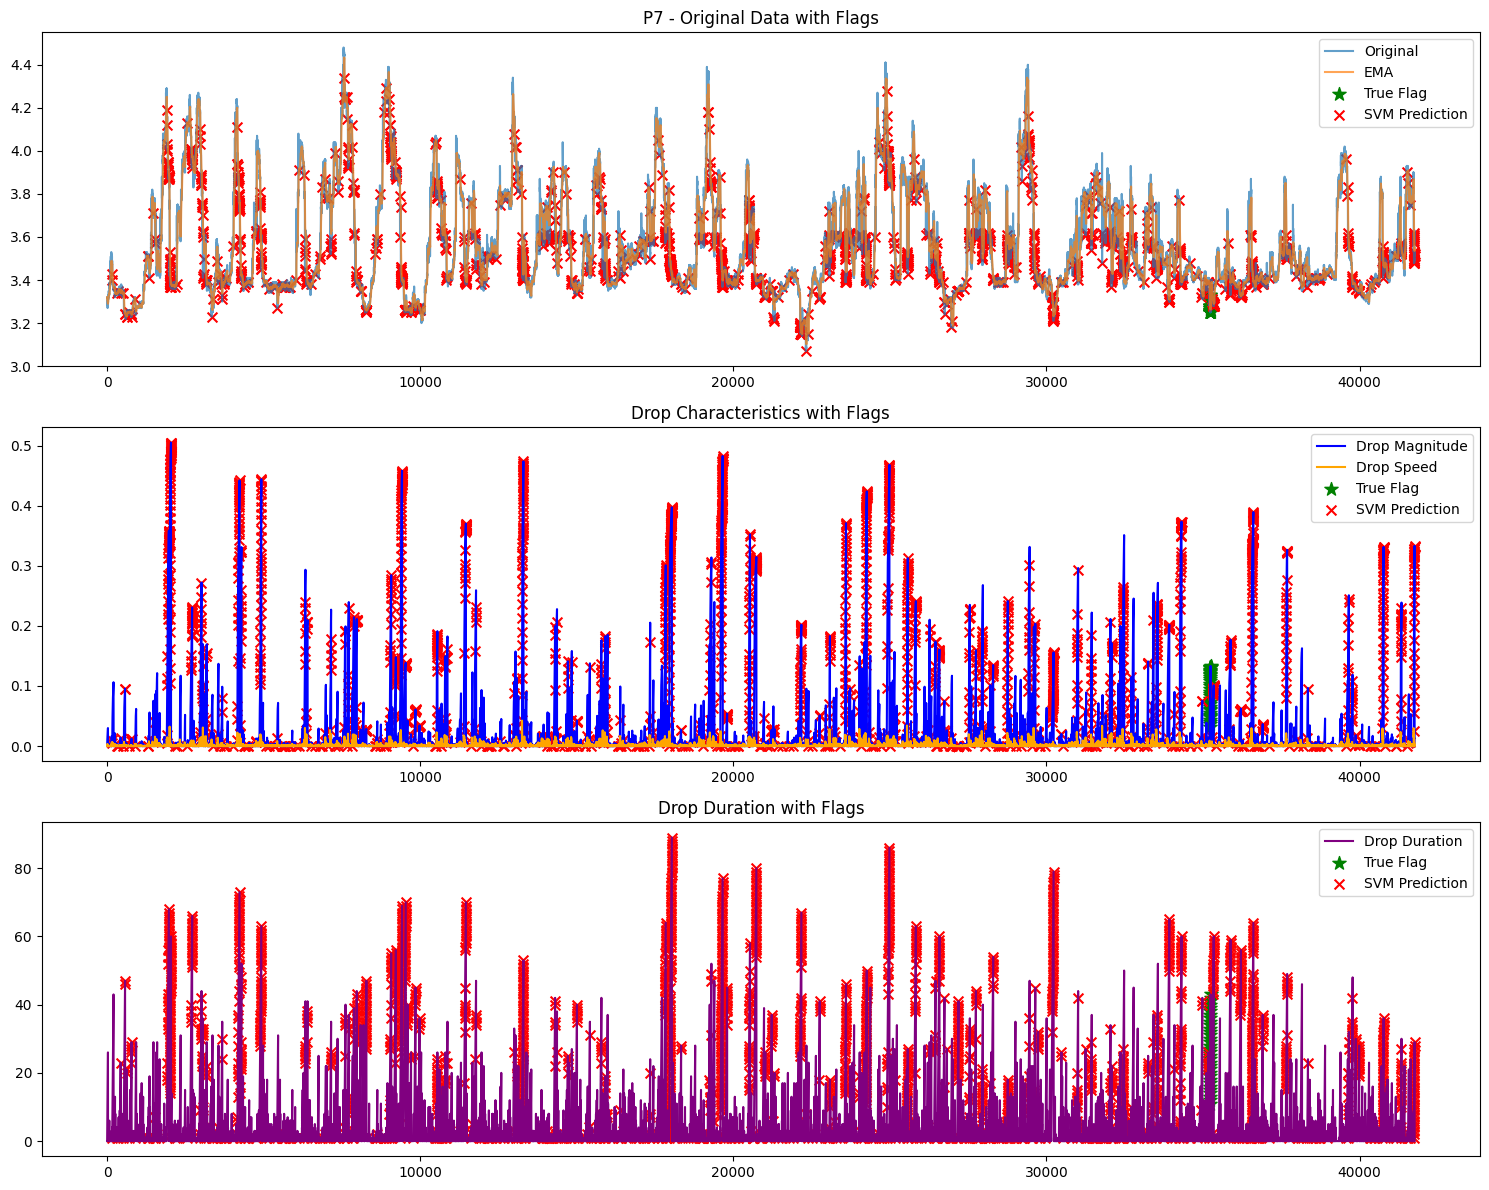

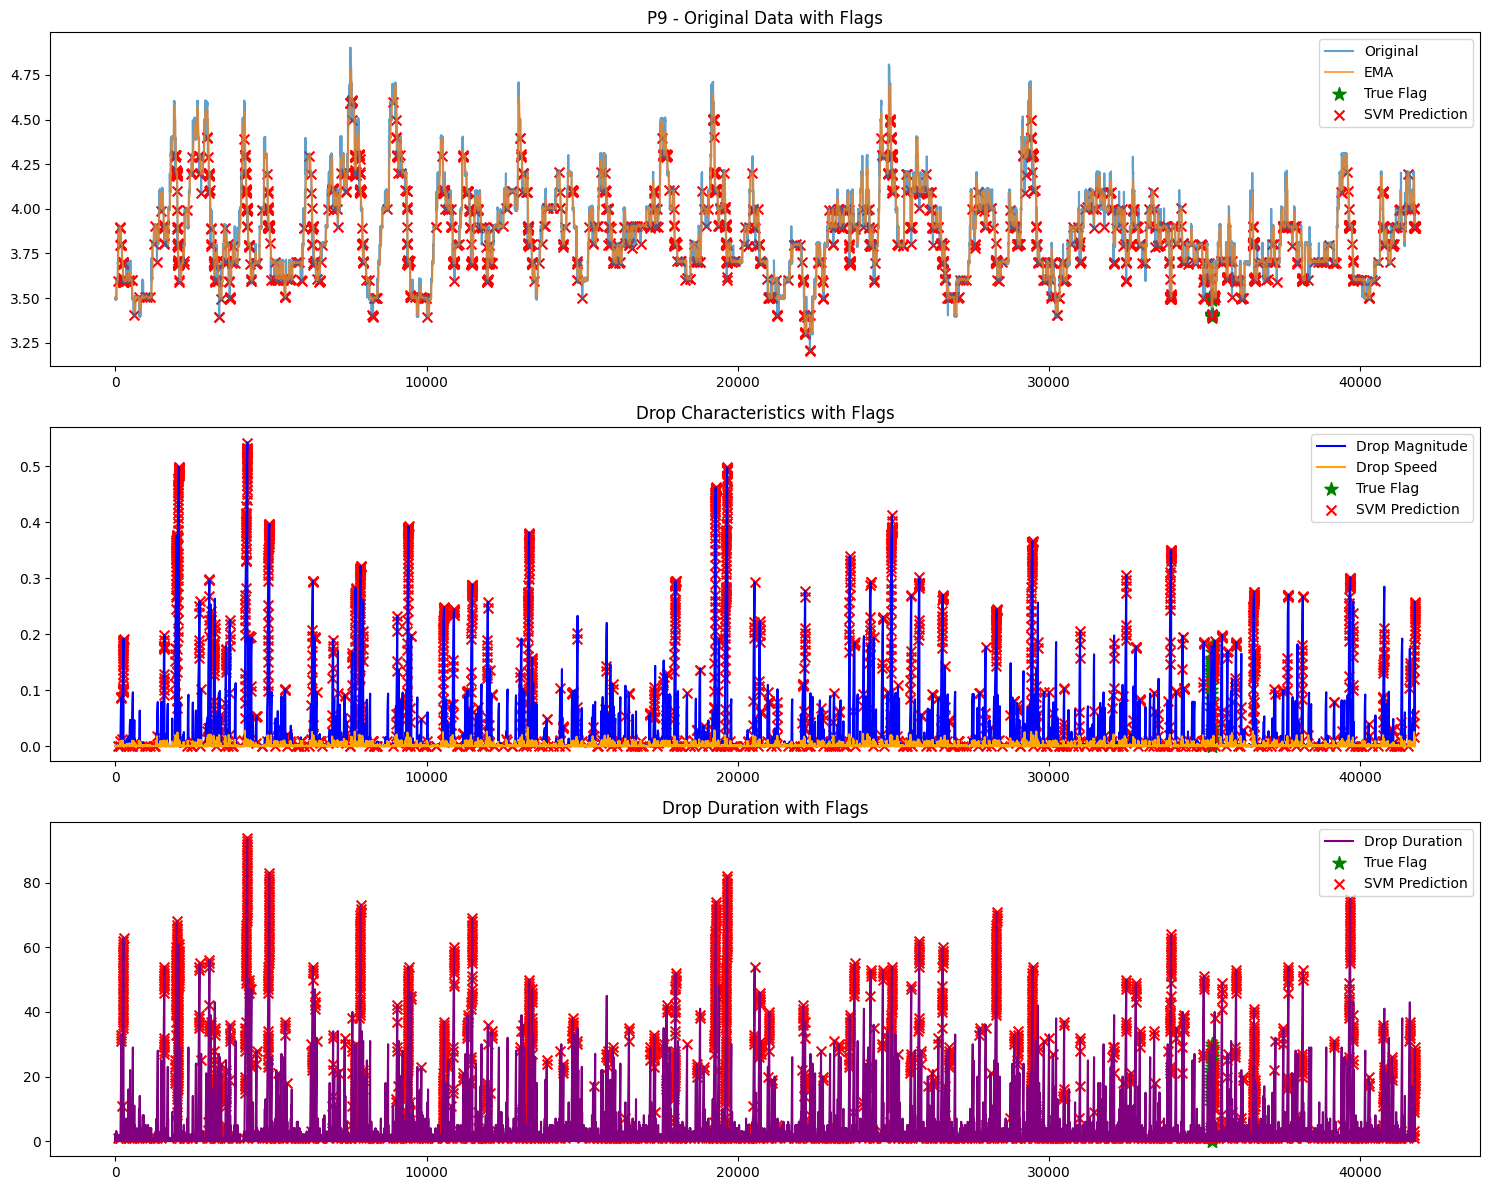

In [23]:
def plot_preprocessing_results(df_A, preprocessed_df, svm_results, col):
    plt.figure(figsize=(15, 12))
    
    # 원본 데이터와 EMA
    plt.subplot(3, 1, 1)
    plt.plot(df_A[col], label='Original', alpha=0.7)
    plt.plot(preprocessed_df[f'{col}_ema'], label='EMA', alpha=0.7)
    
    # 실제 flag 변화 표시
    true_flags = df_A[df_A[f'{col}_flag'] == 1].index
    plt.scatter(true_flags, df_A.loc[true_flags, col],
               color='green', marker='*', s=100, label='True Flag')
    
    # SVM 예측 표시
    predicted_flags = svm_results[svm_results[f'{col}_svm_anomaly'] == 1].index
    plt.scatter(predicted_flags, df_A.loc[predicted_flags, col],
               color='red', marker='x', s=50, label='SVM Prediction')
    
    plt.title(f'{col} - Original Data with Flags')
    plt.legend()
    
    # 하락 특성과 예측
    plt.subplot(3, 1, 2)
    plt.plot(preprocessed_df[f'{col}_drop_magnitude'], label='Drop Magnitude', color='blue')
    plt.plot(preprocessed_df[f'{col}_drop_speed'], label='Drop Speed', color='orange')
    
    # 실제와 예측 flag 표시
    plt.scatter(true_flags, 
               preprocessed_df.loc[true_flags, f'{col}_drop_magnitude'],
               color='green', marker='*', s=100, label='True Flag')
    plt.scatter(predicted_flags,
               preprocessed_df.loc[predicted_flags, f'{col}_drop_magnitude'],
               color='red', marker='x', s=50, label='SVM Prediction')
    
    plt.title('Drop Characteristics with Flags')
    plt.legend()
    
    # 하락 기간과 예측
    plt.subplot(3, 1, 3)
    plt.plot(preprocessed_df[f'{col}_drop_duration'], label='Drop Duration', color='purple')
    
    # 실제와 예측 flag 표시
    plt.scatter(true_flags,
               preprocessed_df.loc[true_flags, f'{col}_drop_duration'],
               color='green', marker='*', s=100, label='True Flag')
    plt.scatter(predicted_flags,
               preprocessed_df.loc[predicted_flags, f'{col}_drop_duration'],
               color='red', marker='x', s=50, label='SVM Prediction')
    
    plt.title('Drop Duration with Flags')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# P8, P9에 대해 결과 시각화
for col in ['P7','P8', 'P9']:
    plot_preprocessing_results(df_A, preprocessed_df, svm_results, col)

## 이미지와 평가 결과를 분석해보면, SVM 모델의 성능을 개선하기 위해 다음과 같은 방법들을 제안할 수 있습니다:
1. 하락 특성 기반 전처리 개선
Drop Duration 임계값 설정: 연속된 하락 기간이 특정 기간 이상인 경우만 고려
Drop Magnitude 정규화: 하락 폭을 상대적 비율로 변환
Drop Speed와 Duration의 조합 특성 생성
2. SVM 하이퍼파라미터 최적화
nu 값을 0.001로 낮추어 이상치 비율 조정
kernel을 'rbf'에서 'sigmoid'로 변경 시도
gamma 파라미터를 'auto'로 설정하여 특성 간 관계 강화
3. 모델링 전략 수정
하락 구간에 대해서만 SVM 적용
연속된 이상치 탐지 시에만 flag로 판단
급격한 하락이 발생하는 구간의 길이를 고려한 후처리
4. 앙상블 접근
Isolation Forest로 1차 필터링
SVM으로 2차 이상치 탐지
두 모델의 예측이 일치하는 경우만 flag로 판단
이미지에서 보이는 P8, P9의 급격한 하락 패턴과 실제 flag 발생 구간의 특성을 더 잘 반영하도록 이러한 개선이 필요합니다.

`-` 해결해야할 문제 : P 압력계에서 일어나는 이상치를 탐지

- Q1 ~ Q5 : 유량 정량 정보
- M1 ~ M14 : 이진 분류되어진 펌프가동정보, 이산형 데이터 0이면 꺼진거 1이면 켜진거
- P1 ~ P26 : 해당 펌프의 상수도의 압력계 정량 정보 0이면 정상 1이면 이상치!!
- P1_flag ~ P26_flag : 어떠한 P에 이상 탐지 여부, 이진 분류, test set에선 제공되지 않는다
- anomaly : 이상 탐지 여부, train set에서만 존재, P1_flag ~ P26_flag에서 감지되면 해당 변수에서도 체크된다, test set에선 제공되지 않는다
- Data set : $ D_{train} \in R^{n \times m} $ , $n = 1,2,...,44101,\quad m = 1,2,...,73$
- $n$단위는 1분, 결측치 존재 X


# iso forest

In [24]:
def detect_pressure_anomalies_iso(preprocessed_df, pressure_cols, contamination=0.01):
    # 1. 하락 특성 선택
    drop_features = []
    for col in pressure_cols:
        drop_features.extend([
            f'{col}_drop_duration',
            f'{col}_drop_magnitude',
            f'{col}_drop_speed'
        ])
    
    # 결측치 처리
    features_df = preprocessed_df[drop_features].fillna(0)
    
    # 2. Isolation Forest 적용
    iso = IsolationForest(
        contamination=0.1,
        random_state=42,
        n_estimators=100
    )
    
    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features_df)
    
    # 예측
    predictions = iso.fit_predict(X_scaled)
    anomalies = np.where(predictions == -1, 1, 0)
    
    # 3. SHAP 값 계산
    explainer = shap.TreeExplainer(iso)
    shap_values = explainer.shap_values(X_scaled)
    
    # 4. 각 Pi별 영향도 분석
    feature_importance = {}
    for i, feature in enumerate(drop_features):
        feature_importance[feature] = np.mean(np.abs(shap_values[:, i]))
    
    # 영향도 기반 Pi_flag 예측
    results = pd.DataFrame()
    results['iso_anomaly'] = anomalies
    
    # Pi별 flag 설정
    for col in pressure_cols:
        col_features = [f for f in drop_features if col in f]
        col_importance = sum(feature_importance[f] for f in col_features)
        results[f'{col}_importance'] = col_importance
        
        # 중요도와 anomaly 결합하여 flag 예측
        results[f'{col}_flag_pred'] = (
            (results['iso_anomaly'] == 1) & 
            (results[f'{col}_importance'] > np.mean(list(feature_importance.values())))
        ).astype(int)
    
    return results, feature_importance

In [25]:
# 모델 적용
results, importance = detect_pressure_anomalies_iso(preprocessed_df, pressure_cols)

In [26]:
# 결과 시각화
def plot_importance_and_predictions(importance, results, original_df):
    plt.figure(figsize=(12, 6))
    
    # 특성 중요도 시각화
    importance_df = pd.DataFrame(
        list(importance.values()),
        index=list(importance.keys())
    ).sort_values(0, ascending=True)
    
    plt.barh(range(len(importance_df)), importance_df[0])
    plt.yticks(range(len(importance_df)), importance_df.index)
    plt.title('Feature Importance based on SHAP values')
    plt.tight_layout()
    plt.show()
    
    # P8, P9 예측 결과 시각화
    for col in ['P8', 'P9']:
        plt.figure(figsize=(15, 5))
        plt.plot(original_df[col], label='Original', alpha=0.7)
        
        # 실제 flag
        true_flags = original_df[original_df[f'{col}_flag'] == 1].index
        plt.scatter(true_flags, original_df.loc[true_flags, col],
                   color='green', marker='*', s=100, label='True Flag')
        
        # 예측 flag
        pred_flags = results[results[f'{col}_flag_pred'] == 1].index
        plt.scatter(pred_flags, original_df.loc[pred_flags, col],
                   color='red', marker='x', s=50, label='Predicted Flag')
        
        plt.title(f'{col} - Predictions vs True Flags')
        plt.legend()
        plt.show()

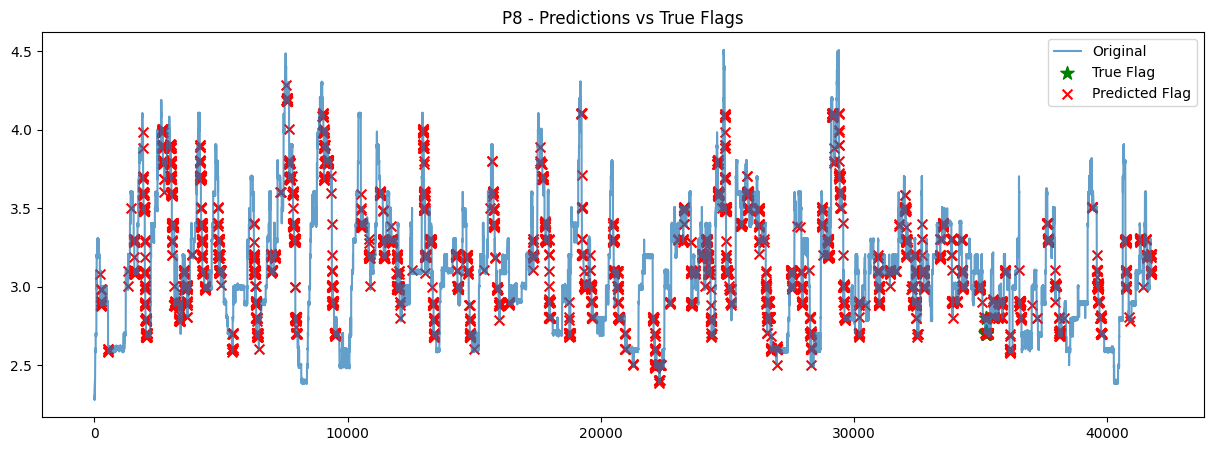

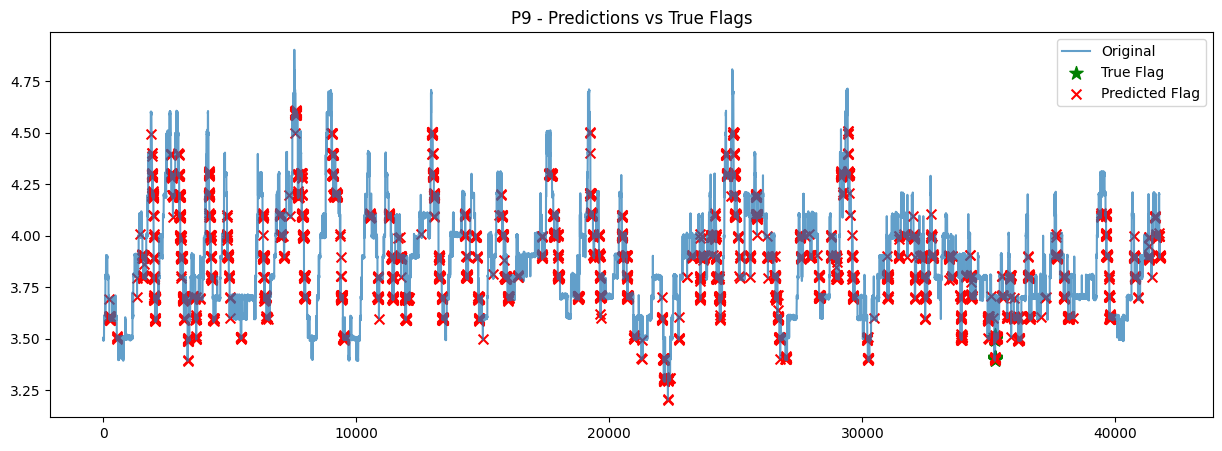

In [27]:
# 결과 시각화
plot_importance_and_predictions(importance, results, df_A)

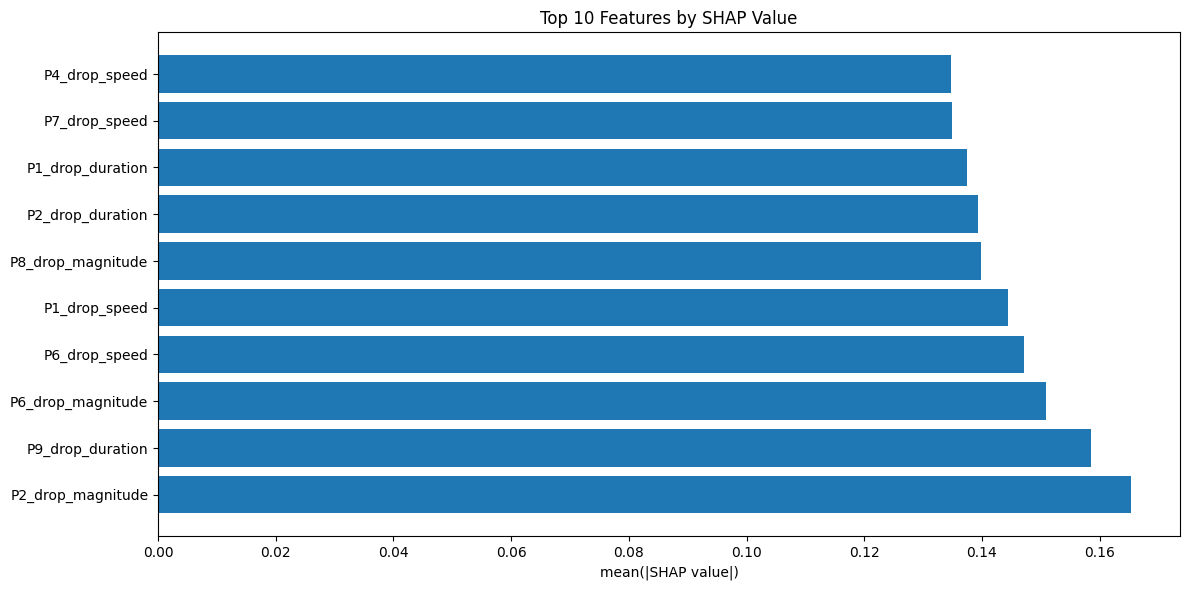


Top 10 Most Important Features:
P2_drop_magnitude: 0.1654
P9_drop_duration: 0.1585
P6_drop_magnitude: 0.1509
P6_drop_speed: 0.1472
P1_drop_speed: 0.1444
P8_drop_magnitude: 0.1399
P2_drop_duration: 0.1393
P1_drop_duration: 0.1374
P7_drop_speed: 0.1349
P4_drop_speed: 0.1348


In [28]:
# feature importance를 DataFrame으로 변환
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
})

# 중요도 기준 정렬 및 상위 10개 추출
top_10_features = importance_df.sort_values('importance', ascending=False).head(10)

# 시각화
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_10_features)), top_10_features['importance'])
plt.yticks(range(len(top_10_features)), top_10_features['feature'])
plt.title('Top 10 Features by SHAP Value')
plt.xlabel('mean(|SHAP value|)')
plt.tight_layout()
plt.show()

# 상위 10개 특성 출력
print("\nTop 10 Most Important Features:")
for idx, row in top_10_features.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")


In [29]:
def evaluate_predictions(df_A, results, pressure_cols):
    # 전체 데이터에 대한 통계
    total_metrics = {
        'true_anomaly': len(df_A[df_A['anomaly'] == 1]),
        'predicted_anomaly': len(results[results['iso_anomaly'] == 1]),
        'total_true_flags': sum(len(df_A[df_A[f'{col}_flag'] == 1]) for col in pressure_cols),
        'total_predicted_flags': sum(len(results[results[f'{col}_flag_pred'] == 1]) for col in pressure_cols)
    }
    
    # 압력계별 평가
    comparison_metrics = []
    for col in pressure_cols:
        true_flags = df_A[df_A[f'{col}_flag'] == 1]
        predicted_flags = results[results[f'{col}_flag_pred'] == 1]
        matching_flags = len(set(true_flags.index) & set(predicted_flags.index))
        
        comparison_metrics.append({
            'Pressure': col,
            'True_Flags': len(true_flags),
            'Predicted_Flags': len(predicted_flags),
            'Matching_Flags': matching_flags,
            'Accuracy': matching_flags/len(true_flags)*100 if len(true_flags) > 0 else 0
        })
    
    metrics_df = pd.DataFrame(comparison_metrics)
    
    # 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 압력계별 Flag 비교
    x = np.arange(len(pressure_cols))
    width = 0.25
    
    ax1.bar(x - width, metrics_df['True_Flags'], width, label='True Flags', color='blue')
    ax1.bar(x, metrics_df['Predicted_Flags'], width, label='Predicted Flags', color='orange')
    ax1.bar(x + width, metrics_df['Matching_Flags'], width, label='Matching Flags', color='green')
    
    ax1.set_xlabel('Pressure')
    ax1.set_ylabel('Count')
    ax1.set_title('Flag Comparison by Pressure')
    ax1.set_xticks(x)
    ax1.set_xticklabels(pressure_cols)
    ax1.legend()
    
    # 전체 통계 비교
    labels = ['Total True\nFlags', 'Total Predicted\nFlags', 'True\nAnomaly', 'Predicted\nAnomaly']
    values = [total_metrics['total_true_flags'], 
              total_metrics['total_predicted_flags'],
              total_metrics['true_anomaly'],
              total_metrics['predicted_anomaly']]
    
    ax2.bar(range(len(labels)), values, color=['blue', 'orange', 'red', 'purple'])
    ax2.set_xticks(range(len(labels)))
    ax2.set_xticklabels(labels)
    ax2.set_title('Total Comparison')
    ax2.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # 상세 결과 출력
    print("\n=== 압력계별 평가 결과 ===")
    print(metrics_df)
    
    print("\n=== 전체 통계 ===")
    print(f"전체 실제 Flag 수: {total_metrics['total_true_flags']}")
    print(f"전체 예측 Flag 수: {total_metrics['total_predicted_flags']}")
    print(f"전체 실제 Anomaly 수: {total_metrics['true_anomaly']}")
    print(f"전체 예측 Anomaly 수: {total_metrics['predicted_anomaly']}")
    
    return metrics_df, total_metrics

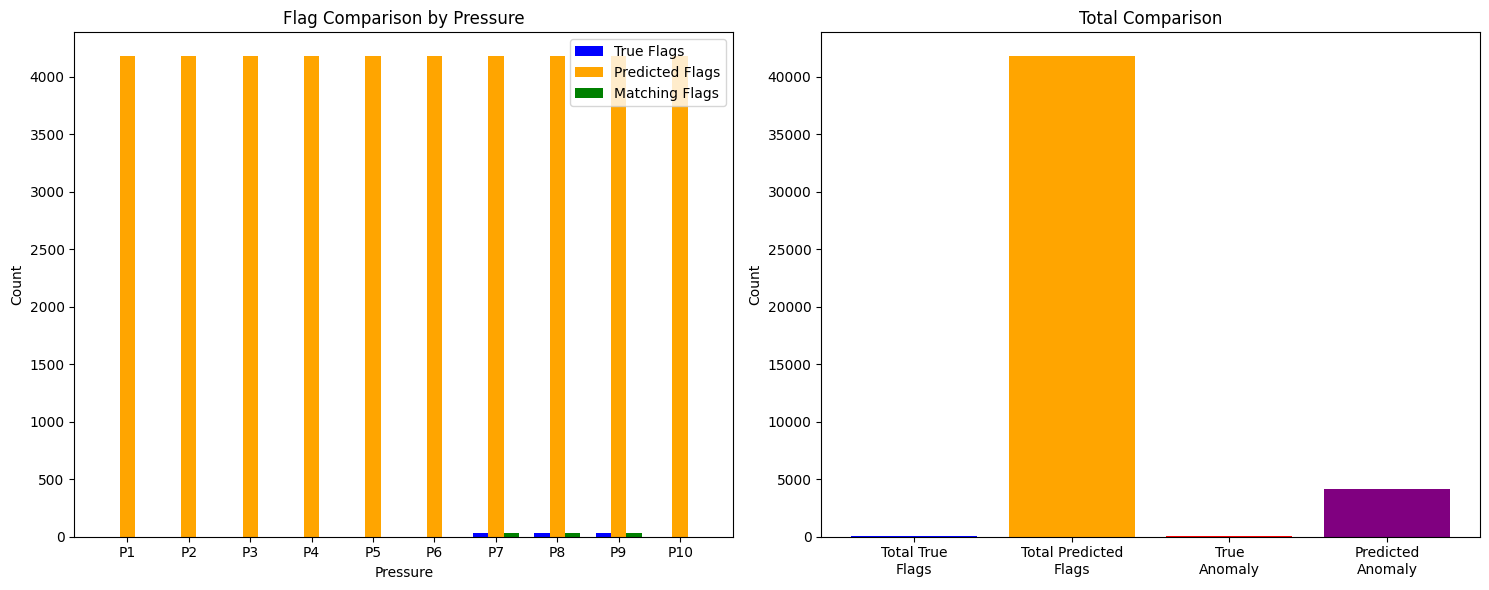


=== 압력계별 평가 결과 ===
  Pressure  True_Flags  Predicted_Flags  Matching_Flags   Accuracy
0       P1           0             4176               0   0.000000
1       P2           0             4176               0   0.000000
2       P3           0             4176               0   0.000000
3       P4           0             4176               0   0.000000
4       P5           0             4176               0   0.000000
5       P6           0             4176               0   0.000000
6       P7          33             4176              29  87.878788
7       P8          33             4176              29  87.878788
8       P9          33             4176              29  87.878788
9      P10           0             4176               0   0.000000

=== 전체 통계 ===
전체 실제 Flag 수: 99
전체 예측 Flag 수: 41760
전체 실제 Anomaly 수: 33
전체 예측 Anomaly 수: 4176


In [30]:
# 평가 실행
metrics_df, total_metrics = evaluate_predictions(df_A, results, pressure_cols)